# WHY FAKE EMAILS A PROBLEM?
**The dataset contains a collection of emails along with their corresponding labels indicating whether they are "ham" or "spam". It can be used for various machine learning and natural language processing tasks, such as email classification and text analysis.**

**The dataset may also include additional features, such as the email subject, sender, and timestamp, that can be used for more advanced analysis and modeling. Overall, the email dataset is a useful resource for studying email communication and developing email-related applications**


(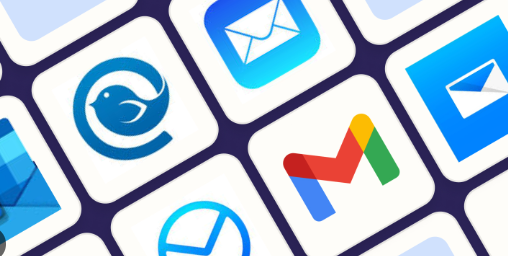) 
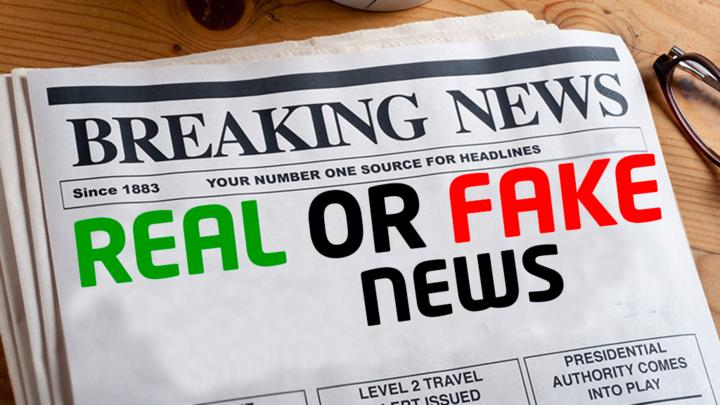

# BRIEF DESCRIPTION OF DATASET
****

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/spam-text-message-classification/SPAM text message 20170820 - Data.csv
/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.25d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.100d.txt


# LOADING THE NECESSARY LIBRARIES

In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from tensorflow.keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

# IMPORTING THE DATASET

In [58]:
df = pd.read_csv('/kaggle/input/spam-text-message-classification/SPAM text message 20170820 - Data.csv')
df

Category                                            Message
0         ham  Go until jurong point, crazy.. Available only ...
1         ham                      Ok lar... Joking wif u oni...
2        spam  Free entry in 2 a wkly comp to win FA Cup fina...
3         ham  U dun say so early hor... U c already then say...
4         ham  Nah I don't think he goes to usf, he lives aro...
...       ...                                                ...
5567     spam  This is the 2nd time we have tried 2 contact u...
5568      ham               Will ü b going to esplanade fr home?
5569      ham  Pity, * was in mood for that. So...any other s...
5570      ham  The guy did some bitching but I acted like i'd...
5571      ham                         Rofl. Its true to its name

[5572 rows x 2 columns]

# DATA VISUALIZATION AND PREPROCESSING

In [59]:
mapping = {'ham':1, 'spam':0}
df['Category'] = df['Category'].map(mapping)

<AxesSubplot:xlabel='Category', ylabel='count'>

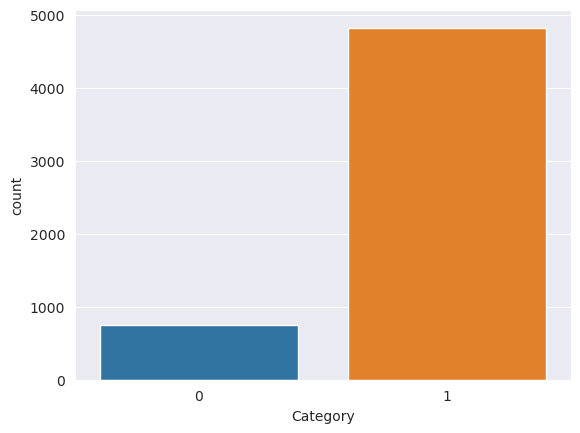

In [63]:
sns.countplot(x='Category', data=df)

**SO, WE CAN SEE THAT THE DATASET IS BALANCED**

In [64]:
df.head()

Category                                            Message
0         1  Go until jurong point, crazy.. Available only ...
1         1                      Ok lar... Joking wif u oni...
2         0  Free entry in 2 a wkly comp to win FA Cup fina...
3         1  U dun say so early hor... U c already then say...
4         1  Nah I don't think he goes to usf, he lives aro...

In [65]:
df.isna().sum() # Checking for nan Values

Category    0
Message     0
dtype: int64

In [67]:
df.Message.count()

5572

**MERGING ALL THE TEXT DATA INTO 1 COLUMN i.e. 'text'**

**WHAT ARE STOPWORDS?**

**Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus. We first download it to our python environment.**

In [68]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

**DATA CLEANING**

In [69]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['Message']=df['Message'].apply(denoise_text)

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


**WORDCLOUD FOR REAL TEXT (LABEL - 1)**

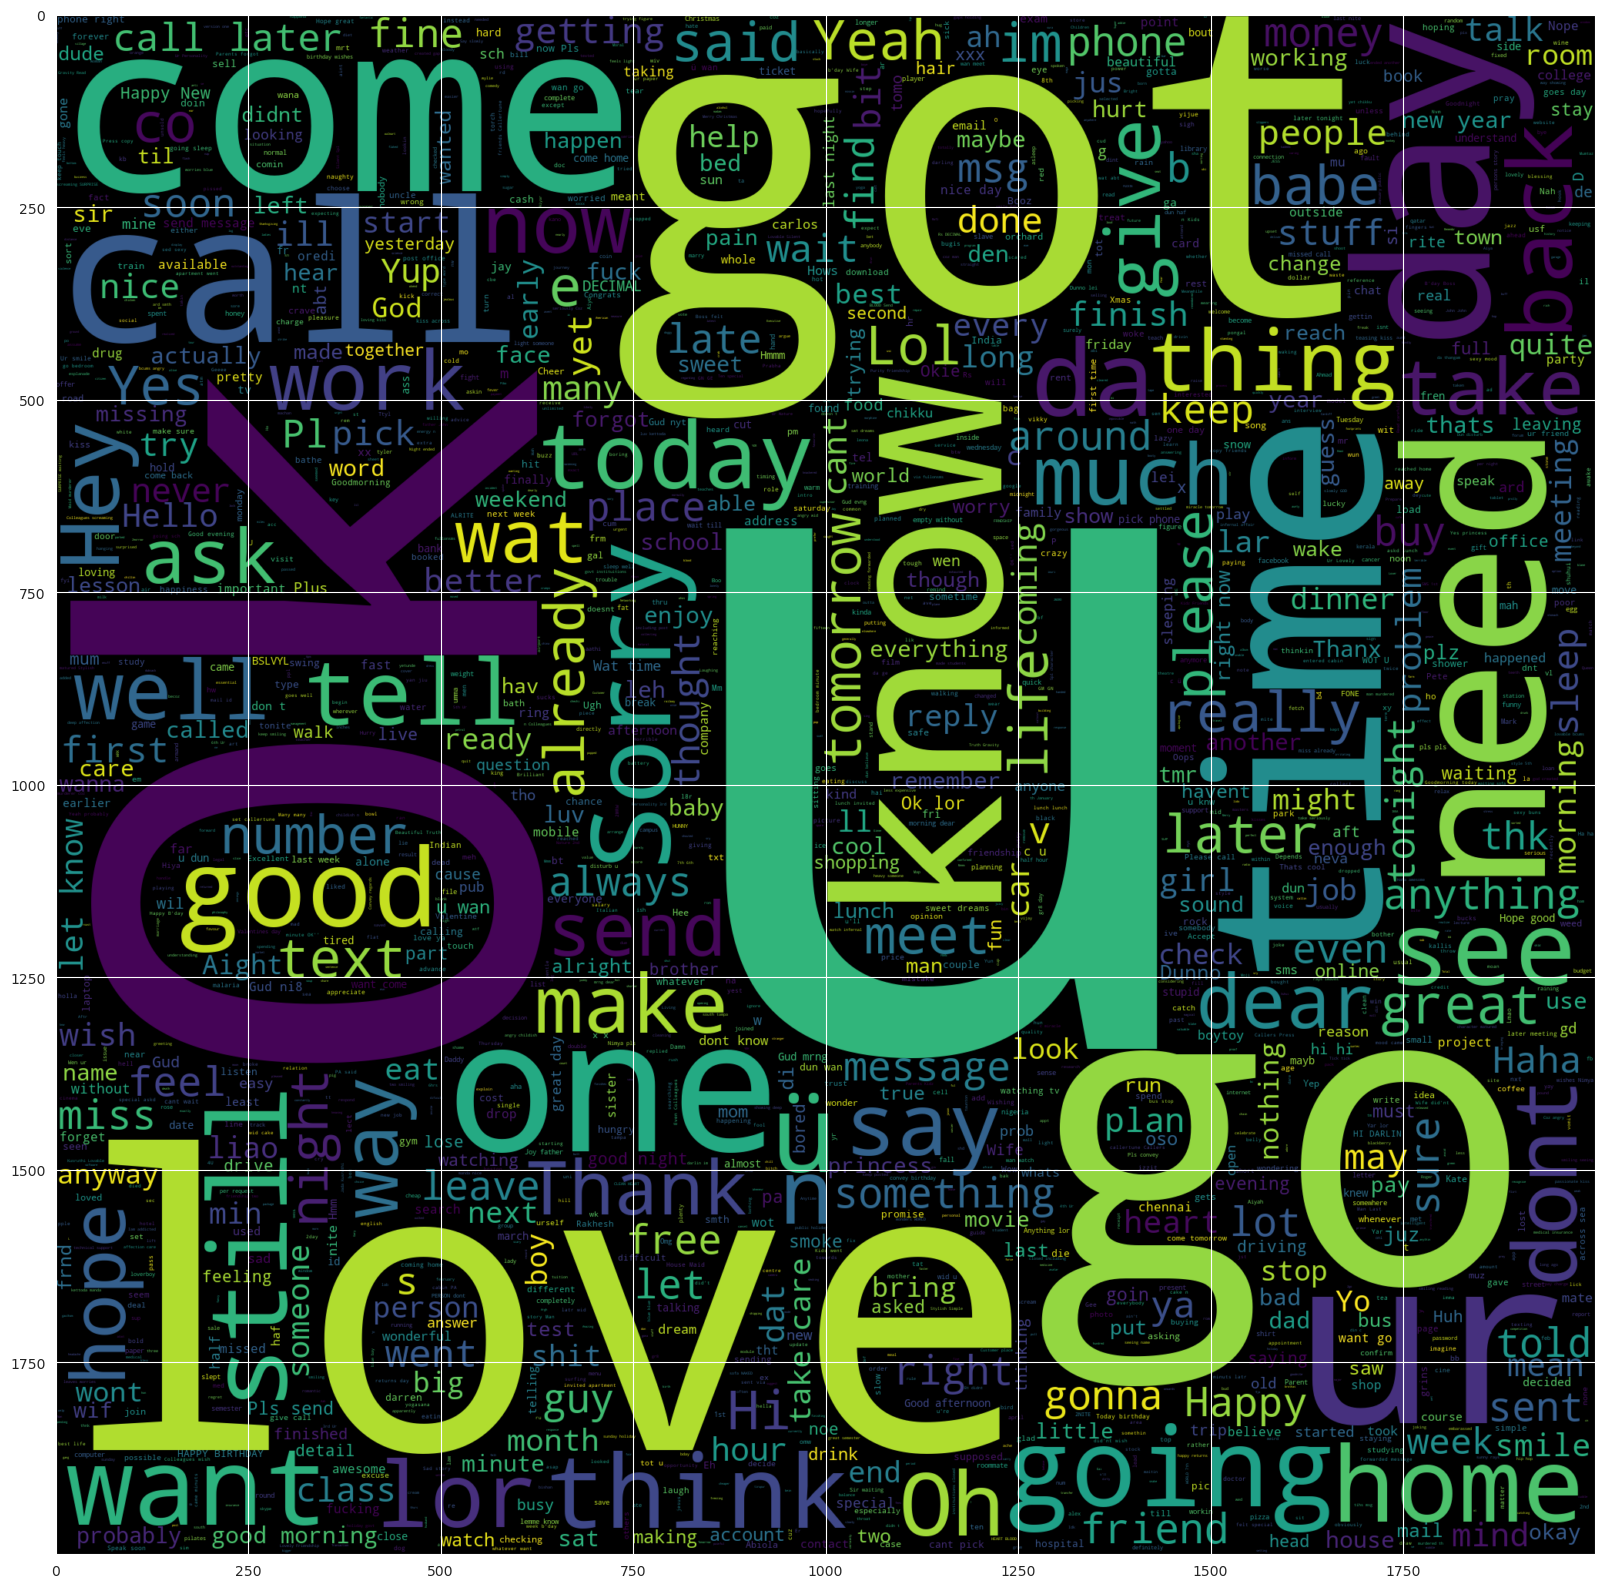

In [76]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.Category == 1].Message))
plt.imshow(wc , interpolation = 'bilinear')

**WORDCLOUD FOR FAKE TEXT (LABEL - 0)**

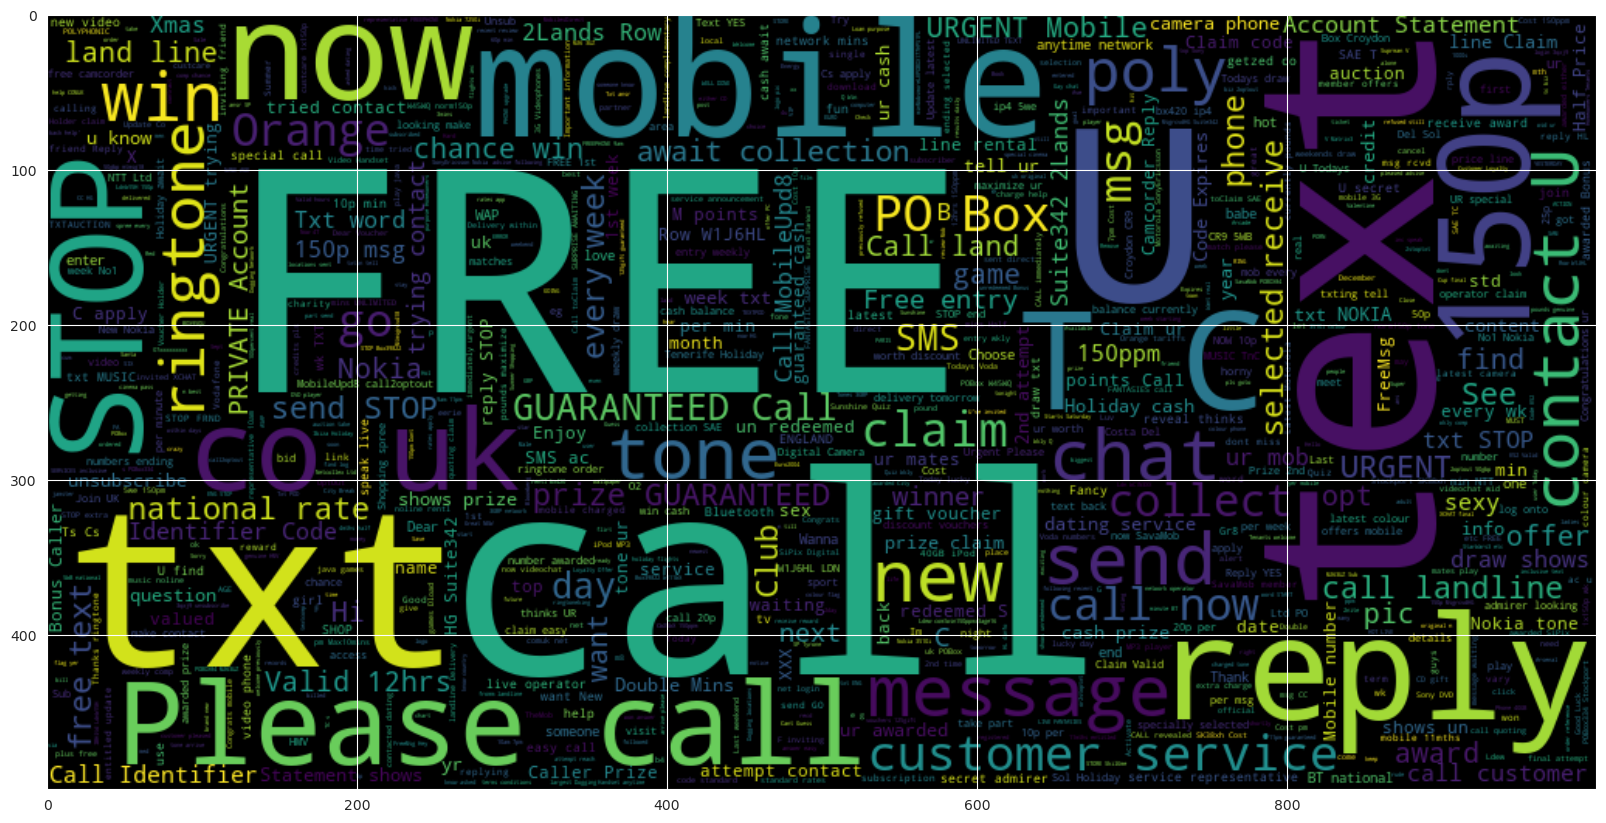

In [73]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(df[df.Category == 0].Message))
plt.imshow(wc , interpolation = 'bilinear')

**Number of characters in texts**

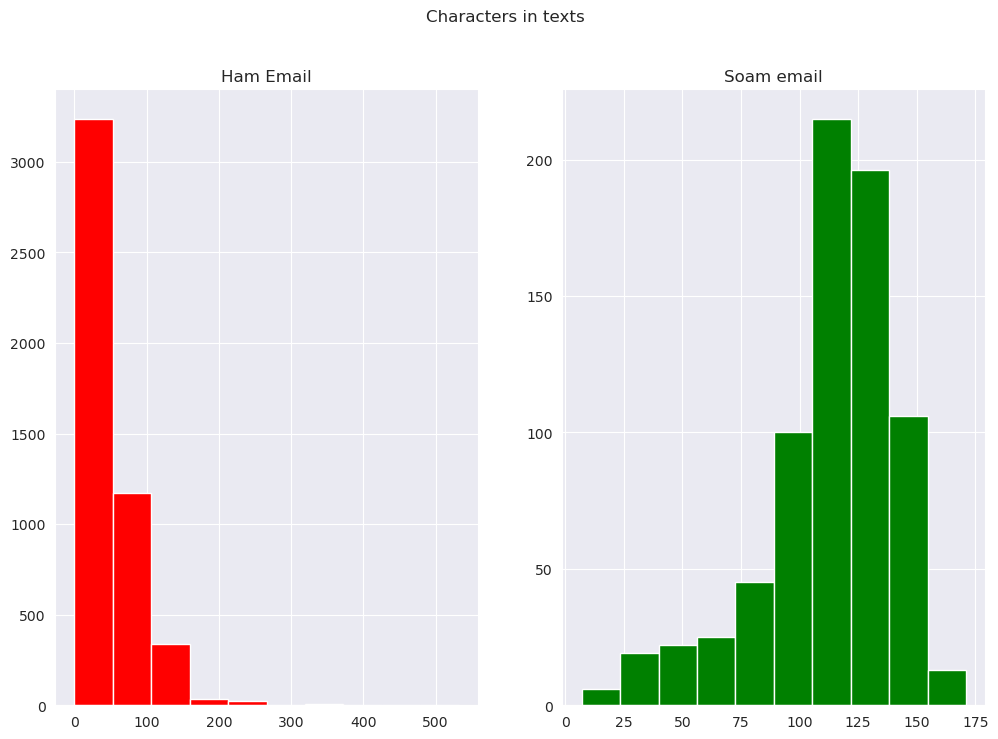

In [78]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['Category']==1]['Message'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Ham Email')
text_len=df[df['Category']==0]['Message'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Soam email')
fig.suptitle('Characters in texts')
plt.show()

**The distribution of both seems to be a a bit  different.**

**Number of words in each text**

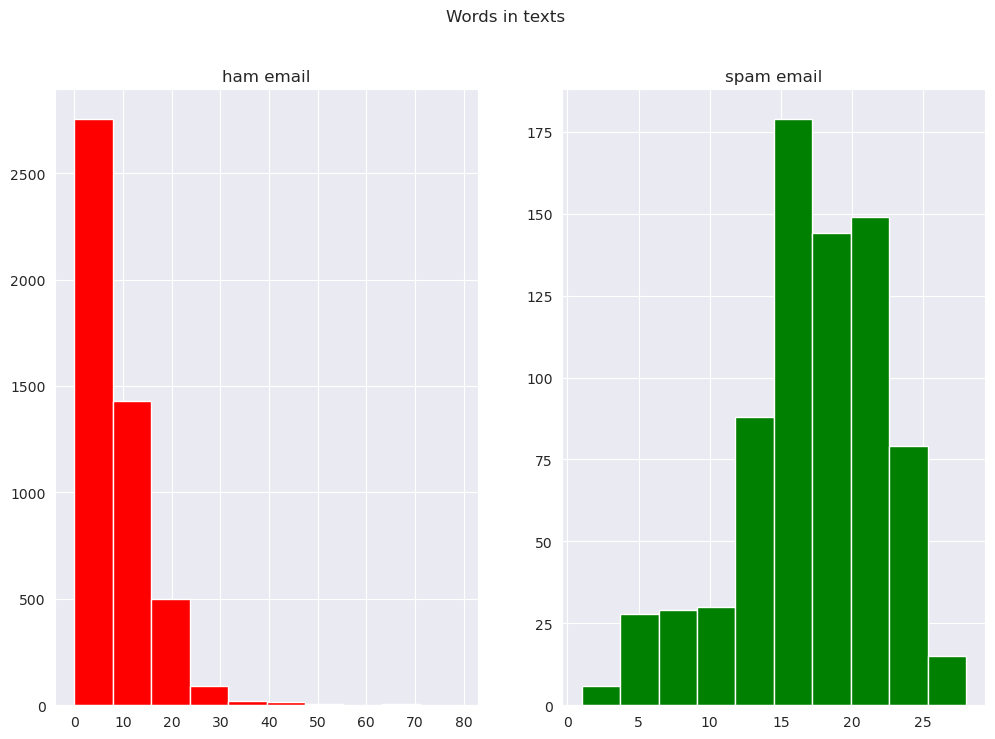

In [79]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['Category']==1]['Message'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('ham email')
text_len=df[df['Category']==0]['Message'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('spam email')
fig.suptitle('Words in texts')
plt.show()

**Average word length in a text**

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code

Text(0.5, 0.98, 'Average word length in each text')

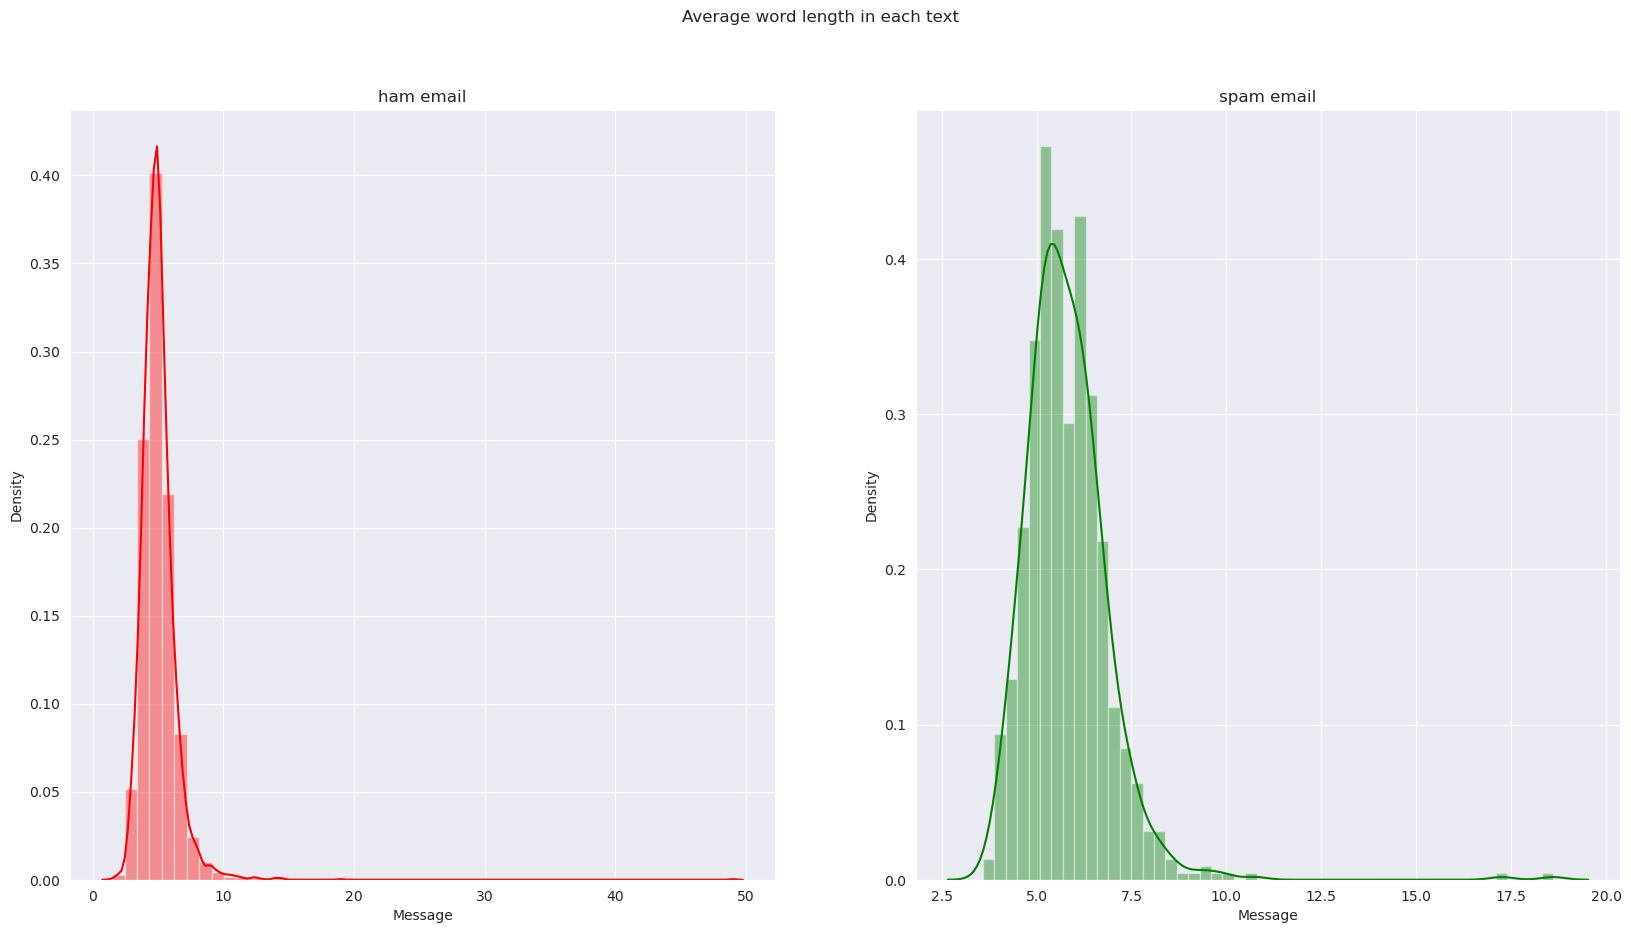

In [80]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['Category']==1]['Message'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('ham email')
word=df[df['Category']==0]['Message'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('spam email')
fig.suptitle('Average word length in each text')

In [82]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.Message)
corpus[:5]

['Go', 'jurong', 'point,', 'crazy..', 'Available']

In [83]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'u': 696,
 '2': 457,
 'call': 374,
 'get': 326,
 'U': 300,
 'ur': 297,
 "I'm": 286,
 '<#>': 276,
 '4': 255,
 'go': 235}

In [84]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

**Unigram Analysis**

<AxesSubplot:>

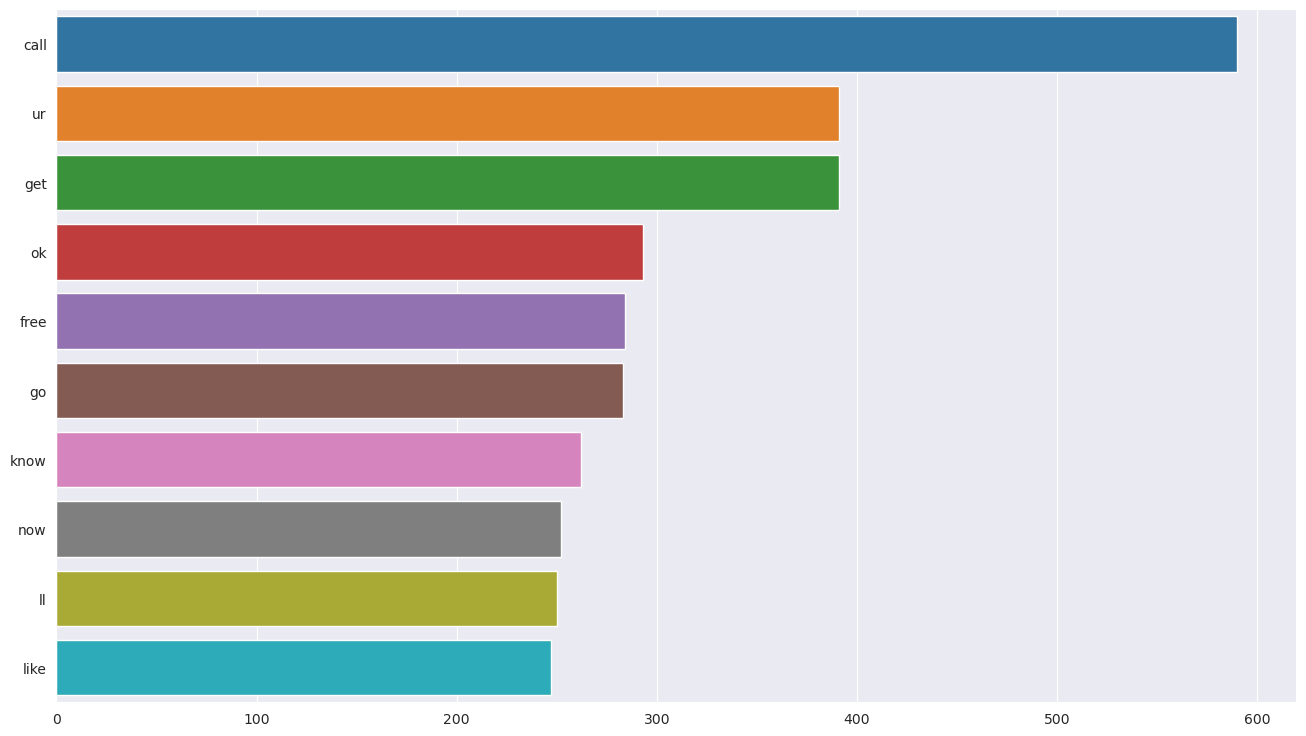

In [88]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.Message,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

**Bigram Analysis**

<AxesSubplot:>

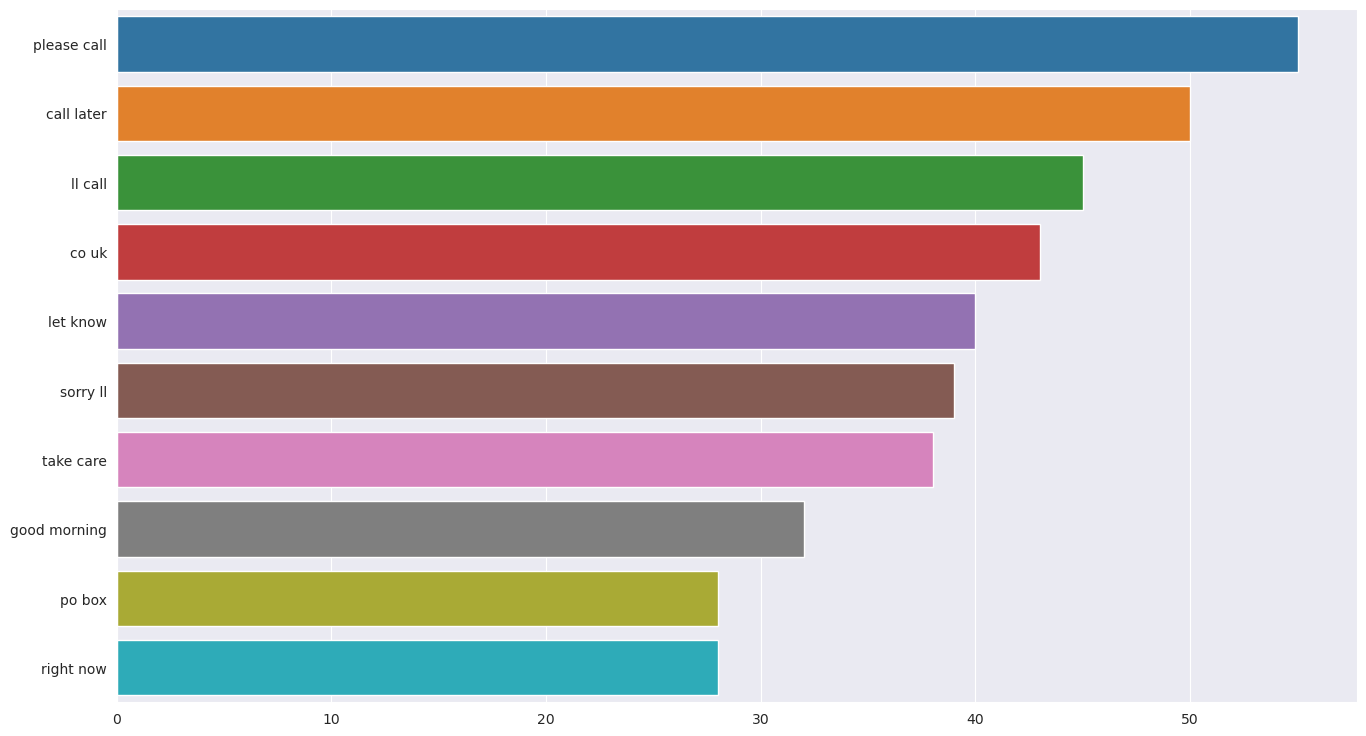

In [89]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.Message,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

**Trigram Analysis**

<AxesSubplot:>

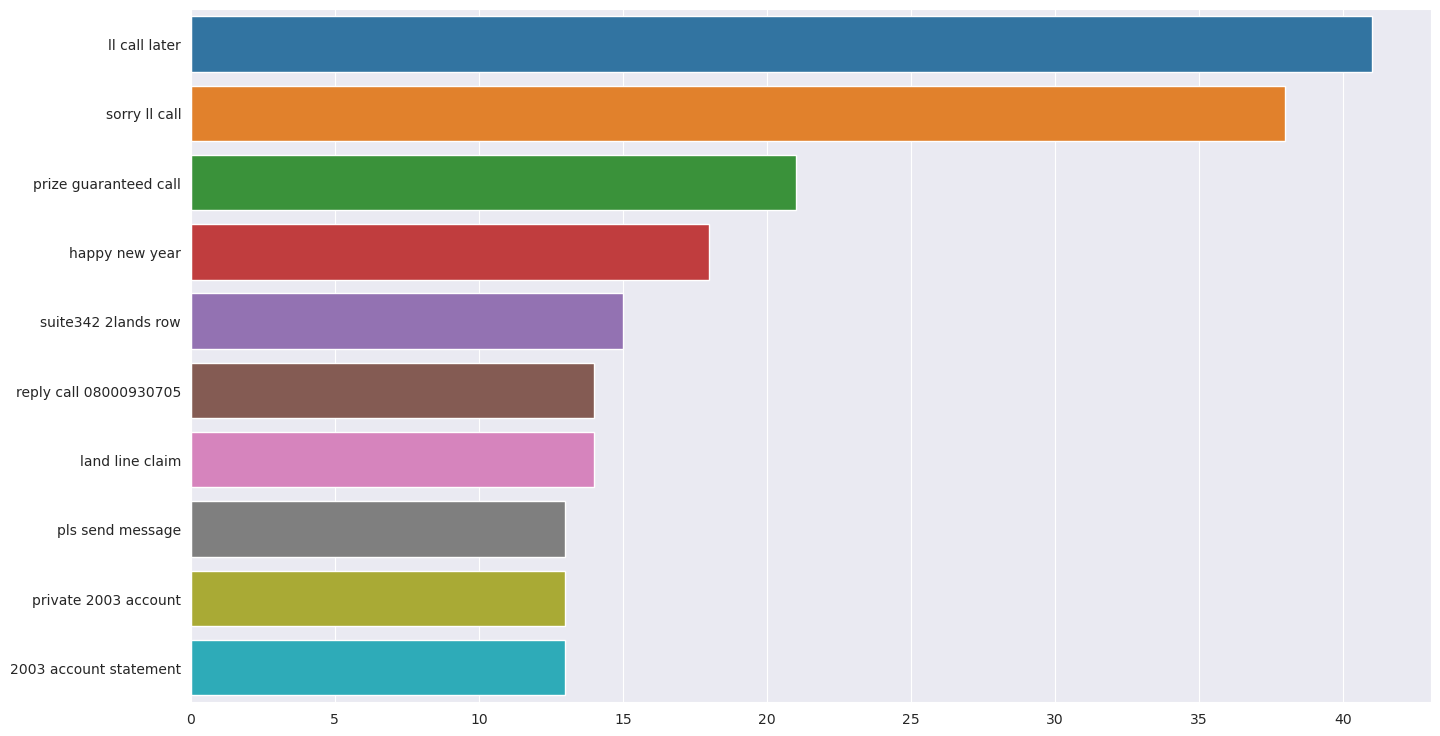

In [90]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.Message,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

**Splitting the data into 2 parts - training and testing data**

In [118]:
x_train,x_test,y_train,y_test = train_test_split(df.Message,df.Category,random_state = 0)

In [119]:
max_features = 7747
maxlen = 300

**Tokenizing Text -> Repsesenting each word by a number**

**Mapping of orginal word to number is preserved in word_index property of tokenizer**

**Tokenized applies basic processing like changing it to lower case, explicitely setting that as False**

**Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones**

In [120]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [121]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

# Introduction to GloVe
**GloVe method is built on an important idea,
You can derive semantic relationships between words from the co-occurrence matrix.
Given a corpus having V words, the co-occurrence matrix X will be a V x V matrix, where the i th row and j th column of X, X_ij denotes how many times word i has co-occurred with word j. An example co-occurrence matrix might look as follows.**
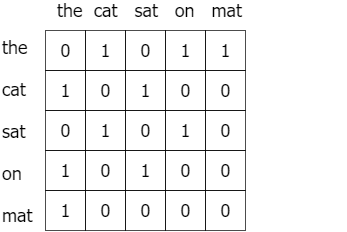

**The co-occurrence matrix for the sentence “the cat sat on the mat” with a window size of 1. As you probably noticed it is a symmetric matrix.
How do we get a metric that measures semantic similarity between words from this? For that, you will need three words at a time. Let me concretely lay down this statement.**

**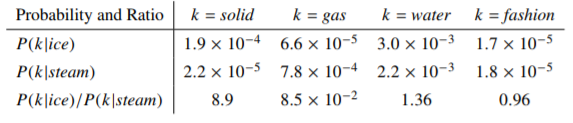
The behavior of P_ik/P_jk for various words
Consider the entity
P_ik/P_jk where P_ik = X_ik/X_i
Here P_ik denotes the probability of seeing word i and k together, which is computed by dividing the number of times i and k appeared together (X_ik) by the total number of times word i appeared in the corpus (X_i).
You can see that given two words, i.e. ice and steam, if the third word k (also called the “probe word”),
is very similar to ice but irrelevant to steam (e.g. k=solid), P_ik/P_jk will be very high (>1),
is very similar to steam but irrelevant to ice (e.g. k=gas), P_ik/P_jk will be very small (<1),
is related or unrelated to either words, then P_ik/P_jk will be close to 1
So, if we can find a way to incorporate P_ik/P_jk to computing word vectors we will be achieving the goal of using global statistics when learning word vectors.**

**Source Credits - https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010**

In [122]:
EMBEDDING_FILE = '/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.100d.txt'

In [123]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [124]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]


In [125]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

In [127]:
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

**Some Model Parameters**

In [128]:
batch_size = 256
epochs = 10
embed_size = 100

In [129]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

# TRAINING THE MODEL

In [130]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [131]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          774700    
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 943,469
Trainable params: 168,769
Non-trainable params: 774,700
_________________________________________________________________


In [132]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
17/17 [==============================] - 57s 3s/step - loss: 0.2276 - accuracy: 0.9280 - val_loss: 0.1062 - val_accuracy: 0.9655 - lr: 0.0100
Epoch 2/10
17/17 [==============================] - 49s 3s/step - loss: 0.0916 - accuracy: 0.9682 - val_loss: 0.0785 - val_accuracy: 0.9742 - lr: 0.0100
Epoch 3/10
17/17 [==============================] - 48s 3s/step - loss: 0.0725 - accuracy: 0.9768 - val_loss: 0.0745 - val_accuracy: 0.9777 - lr: 0.0100
Epoch 4/10
17/17 [==============================] - 48s 3s/step - loss: 0.0555 - accuracy: 0.9818 - val_loss: 0.0672 - val_accuracy: 0.9821 - lr: 0.0100
Epoch 5/10
17/17 [==============================] - 48s 3s/step - loss: 0.0392 - accuracy: 0.9864 - val_loss: 0.0632 - val_accuracy: 0.9821 - lr: 0.0100
Epoch 6/10
17/17 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9888
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
17/17 [==============================] - 48s 3s/step - loss: 0.037

# ANALYSIS AFTER TRAINING OF MODEL

In [133]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

131/131 [==============================] - 14s 106ms/step - loss: 0.0044 - accuracy: 0.9993
Accuracy of the model on Training Data is -  99.92821216583252 %
44/44 [==============================] - 5s 102ms/step - loss: 0.0788 - accuracy: 0.9821
Accuracy of the model on Testing Data is -  98.20531010627747 %


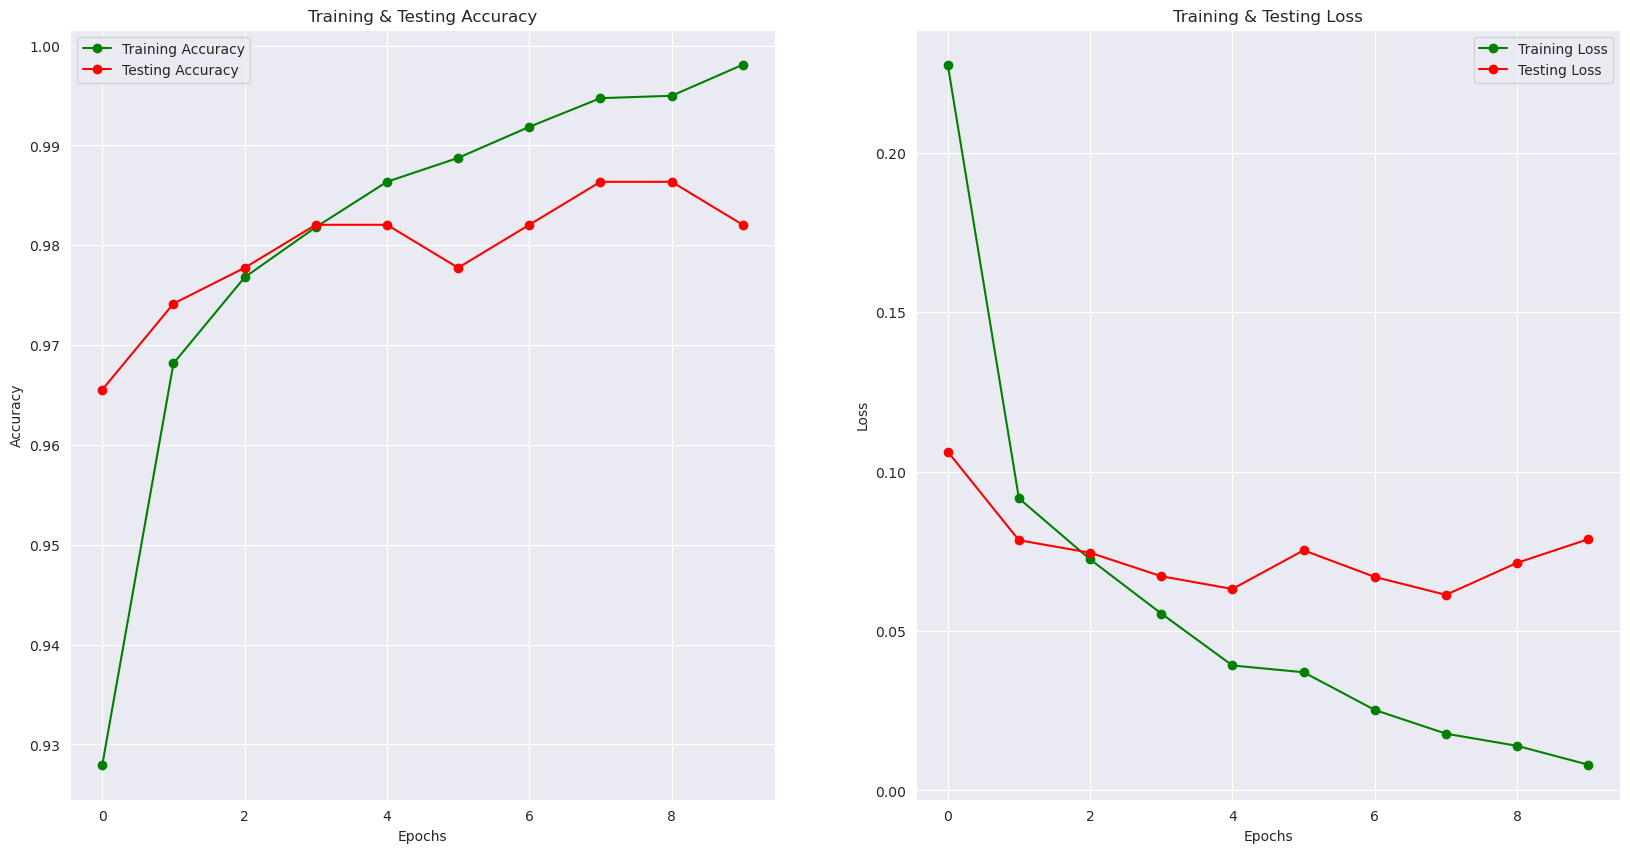

In [134]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [149]:
# pred = model.predict(X_test)
# pred[:5]
# print(classification_report(y_test, pred, target_names = ['ham','spam']))
# cm = confusion_matrix(y_test,pred)
# cm
# cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])
# plt.figure(figsize = (10,10))
# sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")

**PLS UPVOTE THIS NOTEBOOK IF YOU LIKE IT! THANKS FOR YOUR TIME !**